# Plot the AMOC strength and change over time
## Used for
    - hom_P-2Pr_furthergrowth

In [80]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
#from matplotlib import rc
#rc('text',usetex=True)
#rc('text.latex', preamble='\usepackage{color}')
#rc('text.latex', preamble='\usepackage{xcolor}')


In [81]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)


In [82]:
def get_time(y):
    return (y+54783-1-1810)*360-0.5
def get_year(t):
    return (t+0.5)/360 +1810+1-54783
    #return (t+54783-1-1810)*360-0.5
get_time(2010)
get_year(19793519.5)


2010.0

In [83]:
mainfolder=climber_path+"cluster_results/data_Mai8files/"
reffolder=mainfolder
single=False
SSP=False
fut2250=True

#refname="hom_REF"
refname="hom_REF"
folder_ref=reffolder+"c3beta_anthrHeat_"+refname+'/'

In [84]:
data_ref= xr.open_dataset(folder_ref+"history_short.nc", decode_times=False)


# Plot the maximum of the stream fluxes and plot over time

In [85]:
def get_amocs(data_ref, data_p, maxyear=2250):
    upper=10
    lower=20
    print(data_ref.zw_k[upper:lower].values)
    print(data_ref.yt_j[29:40].values)

    AMOC_max=[]
    AMOC_P_max=[]

    years=np.arange(1900, maxyear, step=1)
    for y in years:
        atl_over=data_ref.sel(Time=get_time(y)).atl_over[upper:lower][:,29:40]
        atl_over_p=data_p.sel(Time=get_time(y)).atl_over[upper:lower][:,29:40]
        if y%50==0: print(np.where(atl_over_p == np.max(atl_over_p)), np.max(atl_over_p).values)

        AMOC_max.append(np.max(atl_over))
        AMOC_P_max.append(np.max(atl_over_p))

    AMOC_max=np.array(AMOC_max)
    AMOC_P_max=np.array(AMOC_P_max)
    return years, AMOC_max, AMOC_P_max




In [86]:
def area_mean_lon(x, lats=data_grid.yt_j, lon=data_grid.xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [87]:
    p=xr.open_dataset(folder_p+"history_p2_short.nc", decode_times=False)
p

<xarray.Dataset>
Dimensions:  (Surface: 1, Time: 441, xt_i: 16, xu_i: 16, yt_j: 24, yu_j: 25, zt_k: 10, zw_k: 11)
Coordinates:
  * Surface  (Surface) float32 0.0
  * Time     (Time) float64 1.972e+07 1.972e+07 1.972e+07 1.972e+07 ...
  * xt_i     (xt_i) float32 11.25 33.75 56.25 78.75 101.25 123.75 146.25 ...
  * xu_i     (xu_i) float32 22.5 45.0 67.5 90.0 112.5 135.0 157.5 180.0 ...
  * yt_j     (yt_j) float32 -86.25 -78.75 -71.25 -63.75 -56.25 -48.75 -41.25 ...
  * yu_j     (yu_j) float32 -90.0 -82.5 -75.0 -67.5 -60.0 -52.5 -45.0 -37.5 ...
  * zt_k     (zt_k) float32 0.95 0.85 0.75 0.65 0.55 0.45 0.35 0.25 0.15 0.05
  * zw_k     (zw_k) float32 1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0.0
Data variables:
    ap_ann   (Time, yt_j, xt_i) float64 ...
    ap_djf   (Time, yt_j, xt_i) float64 ...
    ap_jja   (Time, yt_j, xt_i) float64 ...
    cld_ann  (Time, yt_j, xt_i) float64 ...
    cld_djf  (Time, yt_j, xt_i) float64 ...
    cld_jja  (Time, yt_j, xt_i) float64 ...
    co2      (Time) fl

In [88]:
def plot_temp(years):
    ref=xr.open_dataset(folder_ref+"history_p2_short.nc", decode_times=False)
    p=xr.open_dataset(folder_p+"history_p2_short.nc", decode_times=False)
    dt=[]
    for y in years:
        ref_mean=(area_mean_lon(ref.ts_ann.sel(Time=get_time(y))))
        p_mean=(area_mean_lon(p.ts_ann.sel(Time=get_time(y))))
        dt.append(p_mean-ref_mean)
    return np.array(dt)

In [89]:
def plotter(years, AMOC_max,  AMOC_P_max, plot_name, ytextleft, ytextright, post2130text, legendloc=['best', 'best'], leftonly=False):
    from scipy.optimize import curve_fit
    def growth(x,a,b):
        return (a)**(x-2010)*b
    popt,pcov = curve_fit(growth, years,  AMOC_P_max-AMOC_max)

    if leftonly: 
        fig=plt.figure(figsize=(16,5))
        ax1=fig.add_subplot(111)
        ax2=0
    else:
        fig=plt.figure(figsize=(16,5))
        ax1=fig.add_subplot(121)
    
    ax1.plot(years, AMOC_max, '-', color='black',           lw=3,  
             label=("AMOC, " if leftonly else "")+r"Reference Run")
    ax1.plot(years, AMOC_P_max, '-', color='red',           lw=3,  
             label=("AMOC, " if leftonly else "")+r"Run With $P_{\rm hum}$")
    ax1.grid()
    ax1.set_ylabel(r"${\rm AMOC} \ \ [{\rm Sv}]$")
    #ax1.plot([2130, 2130], [ax1.get_ylim()[0], ax1.get_ylim()[1]], '--', color='grey')
    if not leftonly: ax1.text( 2048, ytextleft, r"$2\%$-growth", fontsize=16, color='darkgrey')
    if not leftonly: ax1.text( 2142, ytextleft, post2130text, fontsize=16, color='darkgrey')
    if not leftonly: ax1.set_ylim(ymin=min(ytextleft-0.1, ax1.get_ylim()[0]))
    if not leftonly: ax1.axvline(x=2130, linestyle='--', color='grey')

    if not leftonly:
        ax2=fig.add_subplot(122)
        ax2.plot(years, AMOC_P_max - AMOC_max, '-', color='red' , label=r"$\Delta {\rm AMOC} = {\rm AMOC}_{P_{\rm hum}}  -  {\rm AMOC}_{\rm ref}$", lw=4)
        if runname=="hom_P-2Pr_furthergrowth":
            ax2.plot(years, growth(years, *popt), '--', color='m', lw=3 , 
                 label=r"exp. Fit:    $\Delta {\rm AMOC}=$"+"\n"+r"$"+r'%.3f' % popt[1]+r"\, {\rm Sv}\cdot "+r'%.3f' % popt[0]+r"^{\,yr-2010\,}$")
        ax2.set_ylabel(r"$\Delta \ {\rm AMOC} \ \ [{\rm Sv}]$")
        ax2.grid()
        ax2.text( 2048, ytextright, r"$2\%$-growth", fontsize=16, color='darkgrey')
        ax2.text( 2142, ytextright, post2130text, fontsize=16, color='darkgrey')
        ax2.axvline(x=2130, linestyle='--', color='grey')
        ax2.legend(fontsize=18, loc=legendloc[1])
    else:
        dt=plot_temp(years)
        ax2=ax1.twinx()
        ax2.plot(years, dt, '--', color='blue', lw=2, label=r'$\overline{\Delta T}$')
        ax2.set_ylabel(r"$\overline{\Delta T} \ [{\rm K}]$")
        ax2.set_ylim(ax2.get_ylim()[0]-0.02, ax2.get_ylim()[1])
        ax2.yaxis.label.set_color('blue')
        ax2.tick_params(axis='y', colors='blue')
        ax2.legend(fontsize=18, loc=legendloc[1])
        ax2.set_yticks([-0.01, 0, 0.01])
    
    ax1.legend(fontsize=18, loc=legendloc[0])
    fig.tight_layout()

    plt.savefig(plot_name+".eps", format='eps', bbox_inches='tight')
    return ax1,ax2

[  460.75689697   603.13934326   779.67095947   992.65313721  1243.48986816
  1532.65319824  1859.67089844  2223.1394043   2620.75683594  3049.38110352]
[ 20.625  24.375  28.125  31.875  35.625  39.375  43.125  46.875  50.625
  54.375  58.125]
((array([2]), array([4])), array(15.133559226989746))
((array([2]), array([4])), array(15.01900863647461))
((array([2]), array([4])), array(15.482316970825195))
((array([2]), array([4])), array(14.840487480163574))
((array([2]), array([4])), array(15.269436836242676))
((array([2]), array([4])), array(15.358941078186035))
((array([2]), array([4])), array(14.968271255493164))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3ac368de10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ac340b450>)

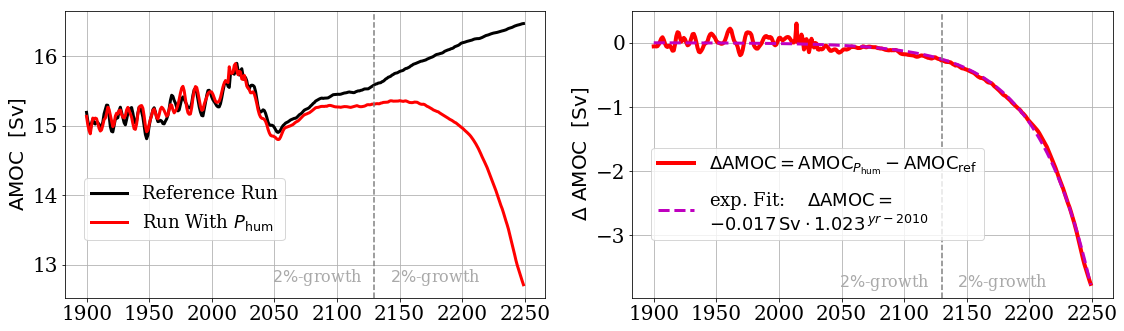

In [90]:
runname="hom_P-2Pr_furthergrowth"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_p= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
plot_name="AMOC_"+runname
years, AMOC_max, AMOC_P_max= get_amocs(data_ref, data_p)
plotter(years, AMOC_max,  AMOC_P_max, plot_name, 12.75, -3.8, r'$2\%$-growth', legendloc=[(0.04, 0.2),(0.04, 0.2)] )

In [91]:
#print("That means: ",popt[1]/0.034," Sv / (W/m^2)")

In [92]:
print("1950", AMOC_max[np.where(years==1950)])
print("1960", AMOC_max[np.where(years==1960)])

('1950', array([ 14.99203491]))
('1960', array([ 15.06451702]))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3ac34c6150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ac32c3090>)

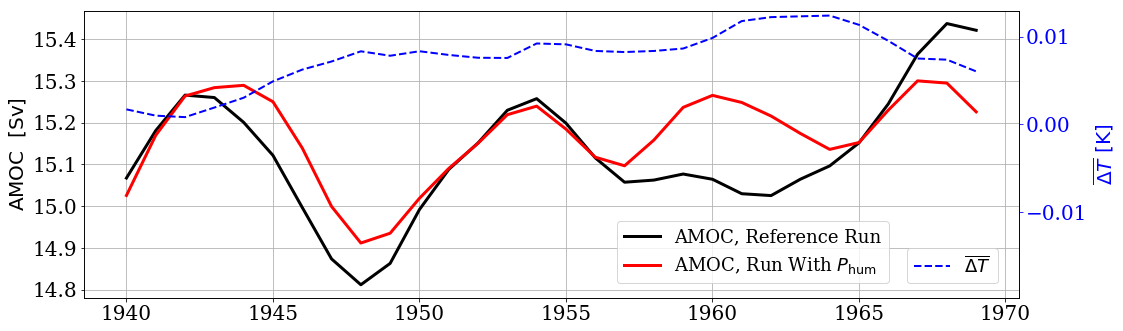

In [93]:
years40_70=years[np.where(years==1940)[0][0]:np.where(years==1970)[0][0]]
AMOC40_70ies=AMOC_max[np.where(years==1940)[0][0]:np.where(years==1970)[0][0]]
AMOC40_70ies_P=AMOC_P_max[np.where(years==1940)[0][0]:np.where(years==1970)[0][0]]
plot_name="AMOC_40to70"
plotter(years40_70, AMOC40_70ies,  AMOC40_70ies_P, plot_name, 
        12.75, -3.8, r'', 
        legendloc=[(0.57, 0.05),(0.88, 0.05)], leftonly=True)

[  460.75689697   603.13934326   779.67095947   992.65313721  1243.48986816
  1532.65319824  1859.67089844  2223.1394043   2620.75683594  3049.38110352]
[ 20.625  24.375  28.125  31.875  35.625  39.375  43.125  46.875  50.625
  54.375  58.125]
((array([2]), array([4])), array(15.133559226989746))
((array([2]), array([4])), array(15.01900863647461))
((array([2]), array([4])), array(15.482316970825195))
((array([2]), array([4])), array(14.840487480163574))
((array([2]), array([4])), array(15.269436836242676))
((array([2]), array([4])), array(15.418066024780273))
((array([2]), array([4])), array(15.858504295349121))
(16.382459131876626, 16.120529556274413, -0.2619295756022133)


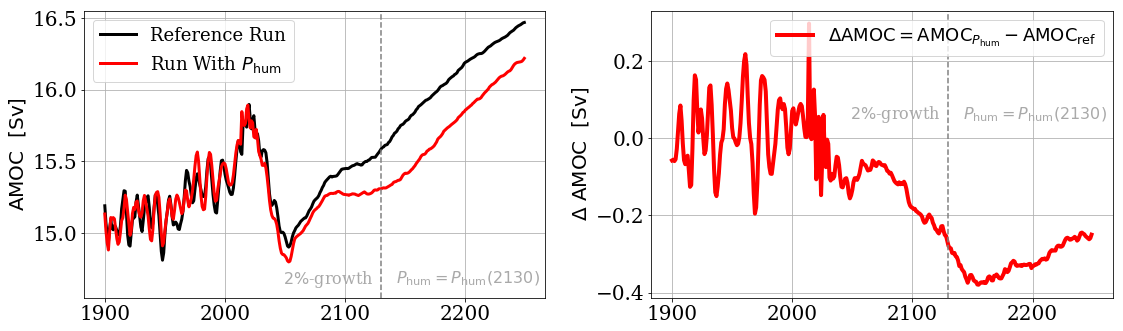

In [94]:
runname="hom_P-2Pr_const"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_p= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
plot_name="AMOC_"+runname
years, AMOC_max, AMOC_P_max= get_amocs(data_ref, data_p)
plotter(years, AMOC_max,  AMOC_P_max, plot_name, 14.65, 0.05, r'$P_{\rm hum} = P_{\rm hum}(2130)$' )
print(np.mean(AMOC_max[-30:]),np.mean(AMOC_P_max[-30:]), np.mean(AMOC_P_max[-30:])-np.mean(AMOC_max[-30:]))


[  460.75689697   603.13934326   779.67095947   992.65313721  1243.48986816
  1532.65319824  1859.67089844  2223.1394043   2620.75683594  3049.38110352]
[ 20.625  24.375  28.125  31.875  35.625  39.375  43.125  46.875  50.625
  54.375  58.125]
((array([2]), array([4])), array(15.133559226989746))
((array([2]), array([4])), array(15.01900863647461))
((array([2]), array([4])), array(15.482316970825195))
((array([2]), array([4])), array(14.840487480163574))
((array([2]), array([4])), array(15.269436836242676))
((array([2]), array([4])), array(15.72945785522461))
((array([2]), array([4])), array(16.194087982177734))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3ac3139f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3ac2ee72d0>)

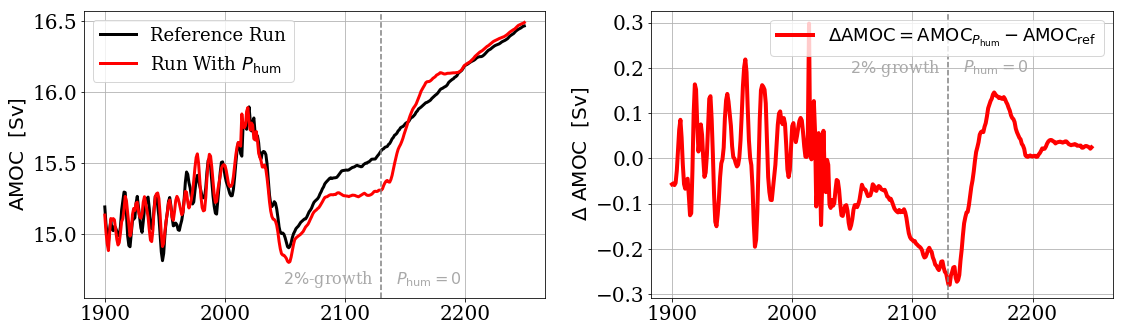

In [95]:
runname="hom_P-2Pr_rev"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_p= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
plot_name="AMOC_"+runname
years, AMOC_max, AMOC_P_max= get_amocs(data_ref, data_p)
plotter(years, AMOC_max,  AMOC_P_max, plot_name, 14.65 , 0.19, r'$P_{\rm hum} = 0$' )

In [96]:
refname2="hom_REF_beyond2250"
folder_ref2=reffolder+"c3beta_anthrHeat_"+refname2+'/'
data_ref2= xr.open_dataset(folder_ref2+"history_short.nc", decode_times=False)


IOError: [Errno 2] No such file or directory: '/home/peter/PIK/climber/cluster_results/data_Mai8files/c3beta_anthrHeat_hom_REF_beyond2250/history_short.nc'

In [97]:
runname="hom_P-2Pr_furthergrowth_equ"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_p2= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
plot_name="AMOC_"+runname
years, AMOC_max, AMOC_P_max= get_amocs(data_ref2, data_p2, maxyear=2270)
#plotter(years, AMOC_max,  AMOC_P_max, plot_name, 12.8, -3.8, r'$2\%$-growth' )

IOError: [Errno 2] No such file or directory: '/home/peter/PIK/climber/cluster_results/data_Mai8files/c3beta_anthrHeat_hom_P-2Pr_furthergrowth_equ/history_short.nc'

In [98]:
atl_over = data_p2.sel(Time=get_time(2251)).atl_over[10:20][:,29:40]
np.max(atl_over)

NameError: name 'data_p2' is not defined

# OCEAN HEAT UPTAKE


<xarray.DataArray 'hflx_ave' (Time: 441)>
array([ -8.957923e-05,  -2.831032e-05,  -8.630635e-06, ...,   4.990522e-06,
         4.990210e-06,   4.970926e-06])
Coordinates:
  * Time     (Time) float64 1.972e+07 1.972e+07 1.972e+07 1.972e+07 ...
Attributes:
    long_name:    heat flux into ocean
    units:        cal/cm**2/s
    valid_range:  [  0.00000000e+00   1.00000002e+20]

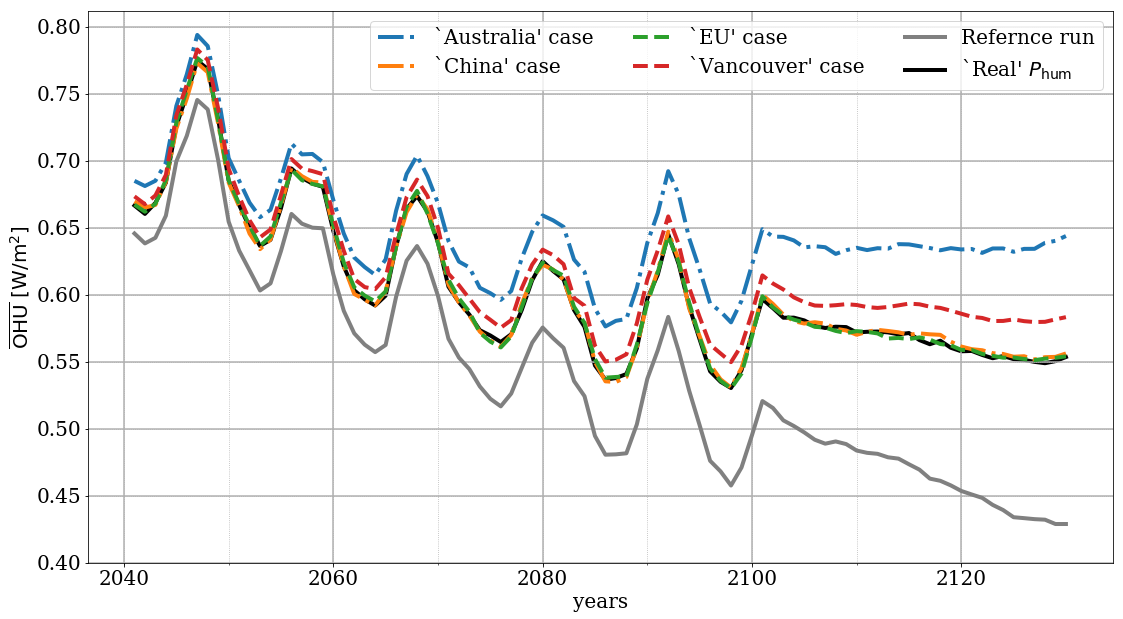

In [99]:
runname="hom_singleAM"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_AM= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)

runname="hom_singleAU"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_Austr= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
runname="hom_singleSH"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_China= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)

runname="hom_singleEU"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_EU= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
runname="hom_singleVA"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_VA= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)


fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
ax.set_xlabel("years")
ax.set_ylabel(r"$\overline{\rm OHU} \ [{\rm W/m^2}]$")
lower=2040
years=get_year(data_Austr.Time[np.where(get_year(data_Austr.Time)>lower)])
ind=np.where(get_year(data_ref.Time[(get_year(data_ref.Time)<2131)])>lower)
ax.plot(years, data_Austr.hflx_ave[ind]*41867.28072, '-.', label="`Australia' case", lw=4)
#ax.plot(years, data_AM.hflx_ave[ind]*41867.28072, '-.', label="`US' case", lw=3)
ax.plot(years, data_China.hflx_ave[ind]*41867.28072, '-.', label="`China' case", lw=4)
ax.plot(years, data_EU.hflx_ave[ind]*41867.28072, '--', label="`EU' case", lw=4)
ax.plot(years, data_VA.hflx_ave[ind]*41867.28072, '--', label="`Vancouver' case", lw=4)
years_ref=get_year(data_ref.Time[ind])
ind_ref=np.where(get_year(data_ref.Time[(get_year(data_ref.Time)<2131)])>lower)
ax.plot(years_ref, data_ref.hflx_ave[ind_ref]*41867.28072, '-', color='grey', label=r"Refernce run", lw=4)
ax.plot(years_ref, data_p.hflx_ave[ind_ref]*41867.28072, '-k', label=r"`Real' $P_{\rm hum}$", lw=4, zorder=-1)
ax.legend(ncol=3)
#from 2010: ax.set_yticks(np.arange(0.4,1.1, step=0.05), minor=True)
ax.set_yticks(np.arange(0.4,0.85, step=0.05), minor=True)
ax.set_xticks(np.arange(lower,2130,step=10), minor=True)
ax.grid(which='major', linewidth=1.5)
ax.grid(which='minor', linestyle=':', linewidth=0.8)
yarrow=(data_p.hflx_ave[ind]*41867.28072)[np.where(years==2120)].values[0]
#ax.annotate(r"\textcolor{red}{China} & "+"\n"+r"\textcolor{green}{EU} &" +"\n"+r"textcolor{black}{`Real'}", xy=(2125, yarrow-0.01), xytext=(2125, yarrow-0.088), arrowprops = dict(color='darkgrey', shrink=0.05), color='darkgrey')
fig.tight_layout()
plt.savefig("HeatFluxOcean.eps", bbox_inches='tight')

data_ref.hflx_ave

[ 0.12716407]
[ 0.07570404]
[ 0.07368833]
[ 0.09108108]
[ 0.08292603]
[ 0.07573462]


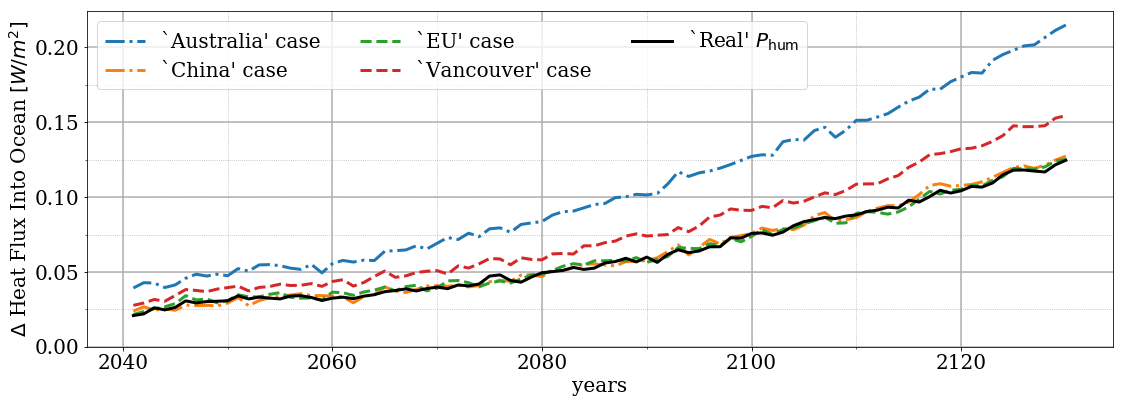

In [17]:
fig=plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
ax.set_xlabel("years")
ax.set_ylabel(r"$\Delta$ Heat Flux Into Ocean $[W/m^2]$")
lower=2040

years_ref=get_year(data_ref.Time[ind])
ind_ref=np.where(get_year(data_ref.Time[(get_year(data_ref.Time)<2131)])>lower)
refdata=data_ref.hflx_ave[ind_ref]*41867.28072

years=get_year(data_Austr.Time[np.where(get_year(data_Austr.Time)>lower)])
ind=np.where(get_year(data_ref.Time[(get_year(data_ref.Time)<2131)])>lower)

ax.plot(years, data_Austr.hflx_ave[ind]*41867.28072-refdata, '-.', label="`Australia' case", lw=3)
#ax.plot(years, data_AM.hflx_ave[ind]*41867.28072-refdata, '-.', label="`US' case", lw=3)
ax.plot(years, data_China.hflx_ave[ind]*41867.28072-refdata, '-.', label="`China' case", lw=3)
ax.plot(years, data_EU.hflx_ave[ind]*41867.28072-refdata, '--', label="`EU' case", lw=3)
ax.plot(years, data_VA.hflx_ave[ind]*41867.28072-refdata, '--', label="`Vancouver' case", lw=3)
ax.plot(years, data_p.hflx_ave[ind_ref]*41867.28072 -refdata, '-k', label=r"`Real' $P_{\rm hum}$", lw=3)

ax.legend(ncol=3)
ax.set_yticks(np.arange(0.0,0.2, step=0.025), minor=True)
ax.set_xticks(np.arange(lower,2130,step=10), minor=True)
ax.grid(which='major', linewidth=1.5)
ax.grid(which='minor', linestyle=':', linewidth=0.8)
fig.tight_layout()
plt.savefig("HeatFluxOceanDelta.eps", bbox_inches='tight')

data_ref.hflx_ave
for i in [data_Austr, data_China, data_EU, data_VA, data_AM, data_p]:
    print((i.hflx_ave[ind]*41867.28072-refdata)[np.where(years==2100)].values)

# TESTS

### Plot only until 2100

In [13]:
runname="hom_P-2Pr_const"
folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
data_p= xr.open_dataset(folder_p+"history_short.nc", decode_times=False)
plot_name="AMOC_"+runname+"_2100"
years, AMOC_max, AMOC_P_max= get_amocs(data_ref, data_p)
len(AMOC_max)
#plotter(years, AMOC_max,  AMOC_P_max, plot_name, 14.75, 0.19, r'$P_{\rm hum} = 0$' )

[  460.75689697   603.13934326   779.67095947   992.65313721  1243.48986816
  1532.65319824  1859.67089844  2223.1394043   2620.75683594  3049.38110352]
[ 20.625  24.375  28.125  31.875  35.625  39.375  43.125  46.875  50.625
  54.375  58.125]
((array([2]), array([4])), array(15.133559226989746))
((array([2]), array([4])), array(15.01900863647461))
((array([2]), array([4])), array(15.482316970825195))
((array([2]), array([4])), array(14.840487480163574))
((array([2]), array([4])), array(15.269436836242676))
((array([2]), array([4])), array(15.418066024780273))
((array([2]), array([4])), array(15.858504295349121))


350

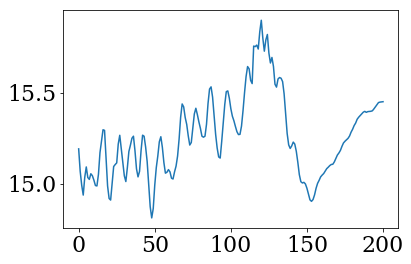

In [14]:
plt.plot(AMOC_max[:201])

### Take the vertical mean flux over 500-3000m?

<xarray.DataArray 'zw_k' (zw_k: 5)>
array([  460.756897,   603.139343,   779.670959,   992.653137,  1243.489868], dtype=float32)
Coordinates:
  * zw_k     (zw_k) float32 460.757 603.139 779.671 992.653 1243.49
Attributes:
    long_name:       Depth of U cell bottom
    units:           m
    cartesian_axis:  Z
    positive:        down
((array([2]), array([4])), array(15.01900863647461))
(array([4]),)
((array([2]), array([4])), array(15.482316970825195))
(array([4]),)
((array([2]), array([4])), array(14.840487480163574))
(array([4]),)
((array([2]), array([4])), array(15.269436836242676))
(array([4]),)
((array([2]), array([4])), array(15.418066024780273))
(array([4]),)
((array([2]), array([4])), array(15.858504295349121))
(array([4]),)
('That means: ', -2.3368683741448679, ' Sv / (W/m^2)')


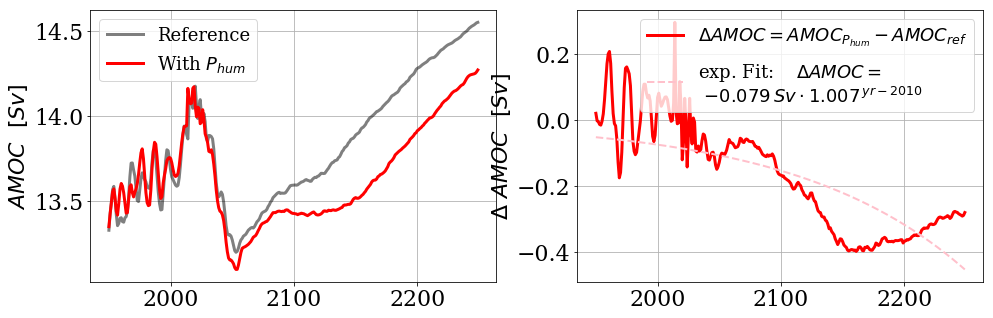

In [15]:
# good values for upper/lower 11-14



upper=10
lower=15
print(data_ref.zw_k[upper:lower])

AMOC=[]
AMOC_P=[]

years=np.arange(1950, 2250, step=1)
for y in years:
    atl_over=data_ref.sel(Time=get_time(y)).atl_over[upper:lower][:,29:40]
    atl_over_p=data_p.sel(Time=get_time(y)).atl_over[upper:lower][:,29:40]
    if y%50==0: print(np.where(atl_over_p == np.max(atl_over_p)), np.max(atl_over_p).values)

    atl_over_mean=atl_over.mean(dim='zw_k')
    atl_over_mean_p=atl_over_p.mean(dim='zw_k')
    if y%50==0: print(np.where(atl_over_mean_p == np.max(atl_over_mean_p)))

    AMOC.append(np.max(atl_over_mean))
    AMOC_P.append(np.max(atl_over_mean_p))

AMOC=np.array(AMOC)
AMOC_P=np.array(AMOC_P)


### Plot the mean of streams over severl height layers


from scipy.optimize import curve_fit
def growth(x,a,b):
    return (a)**(x-2010)*b
popt,pcov = curve_fit(growth, years,  AMOC_P-AMOC)

fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)

ax1.plot(years, AMOC, '-', color='black', alpha=0.5,lw=3,  label="Reference")
ax1.plot(years, AMOC_P, '-', color='red',           lw=3,  label="With $P_{hum}$")
ax1.legend(fontsize=18)
ax1.grid()
ax1.set_ylabel("$AMOC \ \ [Sv]$")

ax2=fig.add_subplot(122)
ax2.plot(years, AMOC_P - AMOC, '-', color='red' , label="$\Delta AMOC = AMOC_{P_{hum}}  -  AMOC_{ref}$", lw=3)
ax2.plot(years, growth(years, *popt), '--', color='pink', lw=2 , 
         label="exp. Fit:    $\Delta AMOC=$ \n $"+r'%.3f' % popt[1]+r"\, Sv\cdot "+r'%.3f' % popt[0]+r"^{\,yr-2010\,}$")
ax2.set_ylabel("$\Delta \ AMOC \ \ [Sv]$")
ax2.grid()
ax2.legend(fontsize=18)

print("That means: ",popt[1]/0.034," Sv / (W/m^2)")

In [18]:
data_p

<xarray.Dataset>
Dimensions:        (Time: 441, xt_i: 96, yt_j: 48, yu_j: 48, zw_k: 25)
Coordinates:
  * Time           (Time) float64 1.972e+07 1.972e+07 1.972e+07 1.972e+07 ...
  * xt_i           (xt_i) float32 1.875 5.625 9.375 13.125 16.875 20.625 ...
  * yt_j           (yt_j) float32 -88.125 -84.375 -80.625 -76.875 -73.125 ...
  * yu_j           (yu_j) float32 -86.25 -82.5 -78.75 -75.0 -71.25 -67.5 ...
  * zw_k           (zw_k) float32 0.0 25.0 50.0 75.0 100.0 126.508 159.012 ...
Data variables:
    acc_max        (Time) float32 ...
    atl_fwf        (Time, yt_j) float32 ...
    atl_hf         (Time, yt_j) float32 ...
    atl_over       (Time, zw_k, yu_j) float32 ...
    deacon_gm_max  (Time) float32 ...
    eta_steric     (Time) float32 ...
    glb_eta        (Time, yt_j, xt_i) float32 ...
    glb_hf         (Time, yt_j) float32 ...
    glb_over       (Time, zw_k, yu_j) float32 ...
    hflx_ave       (Time) float32 ...
    pi_hf          (Time, yt_j) float32 ...
    pi_over     